# Applied Data Science Capstone Week 5 The Battle of Neighborhoods

## Introduction 
### A description of the problem and a discussion of the background
I like Ginza area in Japan.
Because it is one of areas where good restaurants are on in Tokyo, Japan.
So I would like to know neiborhoods that are similar to Ginza of Toronto and NYC.
In other words, neighborhoods that have good restaurants.

### A description of the data and how it will be used to solve the problem.
Price tier and rating of restaurants data of from Foursquare API. 
Category is out of consideration, it must depend on countries.


Retribe venues data of from Foursquare API. Specialy restaurants and shops.
Clustering them.

# Data

## Neighborhoods


### Toronto

I got neighborhoods' latituede and longitude in Toronto from below as this course's week3.
https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
https://cocl.us/Geospatial_data
https://geo.nyu.edu/download/file/nyu-2451-36180-geojson.json

### NYC
https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json


## Venues' data

Use below foursquare's API to get venues in each neighborhoods.
GET https://api.foursquare.com/v2/venues/search
And use below to get venues' price tire and rating.
GET https://api.foursquare.com/v2/venues/VENUE_ID

There is quota to use venue detail API.
So I downloaded its responces and extracted venues' id, name, price tire and rating.


# Methodology 

I used k-means clustering shops by price tire and rating , not by kinds of restaurants.
Because deviation of kinds of restaurants is depends on country.
Ginza is in Japan , so I thought venues in Ginza contain many Japanese restaurants and venues of Toronto and NYC have less Japanese restaurants.

And venus clustered with above result by k-means with number of clusters of venues.
In first ,clustered with percentage of clusters of venues but neighborhoods that have small number of venues were in same cluster as Ginza. They are not similar to Ginza.

# Import libraries



In [1]:
# import modules

import pandas as pd

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn import preprocessing 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib notebook
# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab


from botocore.client import Config
import ibm_boto3
import codecs

import folium # map rendering library


print('Libraries imported.')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
# The code was removed by Watson Studio for sharing.

## The geographical coordinate of Ginza .

In [4]:
ginza_latitude = 35.667
ginza_longitude = 139.767

## Clustering Venues 

I thought that it is better ways to know what neighboorhoods are similar to Ginza that they have similar tier and rating.
Because of quotas of Foursquare api, I saved responses and retrive data that I needed from them.

In [5]:
# define methods

areas = ('Ginza','New York','Toronto')
def get_object_from_cos(key_name):
    """
    Get utf-8-sig object from  IBM Cloud Object Storage
    """
    fileobject = credentials.get_object(Bucket=bucket_name ,Key=key_name)['Body']
    return fileobject

def get_json(key_name):
    """
    read from cos. and parse it as jdon.
    
    
    Parameters
    ----------
    key_names : string
        Key of IBM Cloud Object Storage

    Returns
    -------
    json_data : dict
        dict contain json read
    """
    file_object = get_object_from_cos(key_name)
    str_utf8 = codecs.decode(file_object.read(), encoding='utf-8-sig')
    json_data = json.loads(str_utf8)
    return json_data

def create_dataframe_of_venues(_key_names, _areas):
    """
     retrun Dataframe that contains venus.

    Parameters
    ----------
    _key_names : list of string
        list of key of IBM Cloud Object Storage

    Returns
    -------
    df_venues : pd.DataFrame
        DataFrame of venues
    """
    venues_list = []

    for key_name, area in zip(_key_names, _areas):
        venues_json = get_json(key_name)
        for neiborhood_venus in venues_json["neighborhoods"]:
            for venue in neiborhood_venus["venues"]:
                venue_col = (area, neiborhood_venus["neighborhood"],venue["id"],
                             venue["name"],venue["rating"],venue["tier"],
                            venue["lat"],venue["lng"],
                            )
                venues_list.append( venue_col )
    df_venues = pd.DataFrame([item for item in venues_list])
    df_venues.columns = ['Area','Neighborhood', 
                  'Venue Id', 'Venue Nane', 
                  'Venue Rating', 'Venue Tier',
                  'Venue Lat','Venue Lng'
                        ]
    return df_venues


def read_neighborhood(key_name):
    """
     retrun list of neighborhood names

    Parameters
    ----------
    key_names : string
        key of IBM Cloud Object Storage

    Returns
    -------
    df_venues : pd.DataFrame
        DataFrame of venues
    """    
    json_neighborhoods =  get_json(key_name)
    return [neighborhood['name']  for neighborhood in json_neighborhoods['Neighborhoods']]

In [6]:
df_venues=create_dataframe_of_venues(key_names,areas)
df_venues.head(10)

,Area,Neighborhood,Venue Id,Venue Nane,Venue Rating,Venue Tier,Venue Lat,Venue Lng
0,Ginza,Ginza,4bb5ea01941ad13a2aa21ee3,Grill Bon (新世界 グリル梵),9.0,1,35.667678,139.765306
1,Ginza,Ginza,4b5d1a37f964a520c15229e3,Ku-ta (飯家くーた),8.9,2,35.666170,139.766044
2,Ginza,Ginza,4c4859db1ddec9289235a032,Ginza Ukai-tei (銀座 うかい亭),8.4,4,35.668008,139.767023
3,Ginza,Ginza,4c525974d797e21e9bb18f7d,Ginza Gyuan (銀座 牛庵),8.5,4,35.668950,139.765081
4,Ginza,Ginza,4b766874f964a520594b2ee3,Sushizanmai Okunoin (すしざんまい 奥の院),8.1,2,35.666278,139.769133
5,Ginza,Ginza,4c36fcf693db0f4764ec1e92,すしざんまい 新館,7.9,2,35.666105,139.768895
6,Ginza,Ginza,4d259f871d9fa1cd61234109,Chika no Iki (地下の粋),8.3,2,35.666426,139.770124
7,Ginza,Ginza,4b65376cf964a52048e92ae3,Nair's Restaurant (ナイルレストラン),8.7,2,35.669985,139.767485
8,Ginza,Ginza,4b59bab9f964a520fc9428e3,Sushizanmai (すしざんまい 本店),8.9,2,35.665893,139.770601
9,Ginza,Ginza,4d72073c311f6ea80175d5ea,Tsukiji Itadori Bekkan (築地虎杖 別館),9.0,2,35.665577,139.770448


In [7]:
def plot_venues_of_area(area):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_ylabel('tier')
    ax.set_xlabel('rating')
    ax.set_title('{}\'s venues'.format(area))
    
    area_rows = df_venues[df_venues['Area'] == area]
    area_tier = area_rows['Venue Tier']
    area_ratingr = area_rows['Venue Rating']

    ax.scatter(area_ratingr, area_tier, alpha=0.1)
    plt.show()

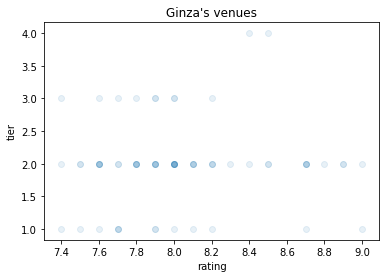

In [8]:
plot_venues_of_area(areas[0])

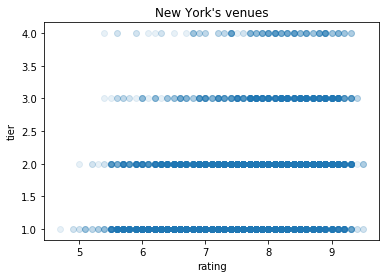

In [9]:
plot_venues_of_area(areas[1])

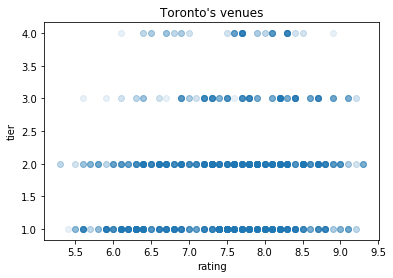

In [10]:
plot_venues_of_area(areas[2])

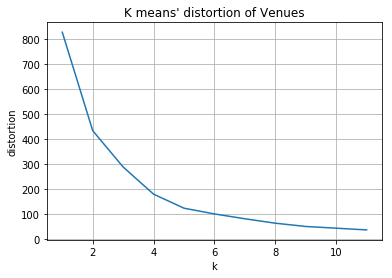

In [11]:
df_data = df_venues.drop(columns=['Area','Neighborhood','Venue Id','Venue Nane','Venue Lat','Venue Lng'],axis='columns')

min_max_scaler = preprocessing.MinMaxScaler()
np_venues = min_max_scaler.fit_transform(df_data.values)

_ks=[]
_inertias=[]
for k in range(1,12):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans_result = kmeans.fit(np_venues)
    _ks.append(k)
    _inertias.append(kmeans_result.inertia_)


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(_ks, _inertias)
ax.set(xlabel='k', ylabel='distortion',
       title='K means\' distortion of Venues')
ax.grid()
plt.show()

In [12]:
k_neighbors = 8

k_venues=5
colors = ['#ff0000','#ffff00','#00ff00','#00ffff','#0000ff','#ff00ff']

kmeans = KMeans(n_clusters=k_venues, random_state=0)
kmeans_result = kmeans.fit(np_venues)

df_venues['Cluster Labels'] = kmeans_result.labels_
df_venues.head(10)

,Area,Neighborhood,Venue Id,Venue Nane,Venue Rating,Venue Tier,Venue Lat,Venue Lng,Cluster Labels
0,Ginza,Ginza,4bb5ea01941ad13a2aa21ee3,Grill Bon (新世界 グリル梵),9.0,1,35.667678,139.765306,2
1,Ginza,Ginza,4b5d1a37f964a520c15229e3,Ku-ta (飯家くーた),8.9,2,35.666170,139.766044,1
2,Ginza,Ginza,4c4859db1ddec9289235a032,Ginza Ukai-tei (銀座 うかい亭),8.4,4,35.668008,139.767023,3
3,Ginza,Ginza,4c525974d797e21e9bb18f7d,Ginza Gyuan (銀座 牛庵),8.5,4,35.668950,139.765081,3
4,Ginza,Ginza,4b766874f964a520594b2ee3,Sushizanmai Okunoin (すしざんまい 奥の院),8.1,2,35.666278,139.769133,1
5,Ginza,Ginza,4c36fcf693db0f4764ec1e92,すしざんまい 新館,7.9,2,35.666105,139.768895,1
6,Ginza,Ginza,4d259f871d9fa1cd61234109,Chika no Iki (地下の粋),8.3,2,35.666426,139.770124,1
7,Ginza,Ginza,4b65376cf964a52048e92ae3,Nair's Restaurant (ナイルレストラン),8.7,2,35.669985,139.767485,1
8,Ginza,Ginza,4b59bab9f964a520fc9428e3,Sushizanmai (すしざんまい 本店),8.9,2,35.665893,139.770601,1
9,Ginza,Ginza,4d72073c311f6ea80175d5ea,Tsukiji Itadori Bekkan (築地虎杖 別館),9.0,2,35.665577,139.770448,1


In [46]:
def plot_clastered_venues(title, area = None):
    """
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.set_ylabel('tier')
    ax.set_xlabel('rating')
    ax.set_title(title)
    for cluster, color in zip(range(k_venues), colors):
        if area == None:
            area_rows = df_venues[(df_venues['Cluster Labels'] == cluster) ]
        else:
            area_rows = df_venues[(df_venues['Cluster Labels'] == cluster) & (df_venues['Area'] == area)]
        area_tier = area_rows['Venue Tier']
        area_ratingr = area_rows['Venue Rating']

        ax.scatter(area_ratingr, area_tier, alpha=0.4, c=color, label='cluster{}'.format(cluster))
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)    
    plt.show()  

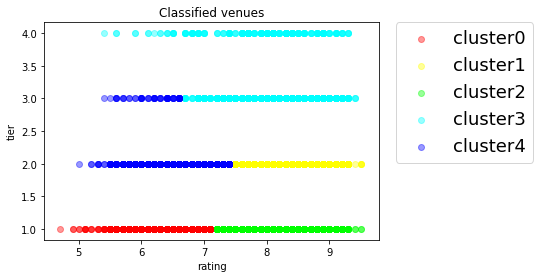

In [47]:
plot_clastered_venues('Classified venues')

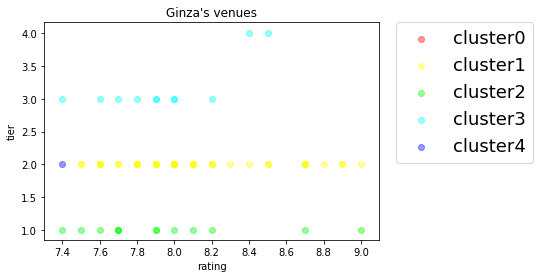

In [48]:
plot_clastered_venues('Ginza\'s venues',areas[0])


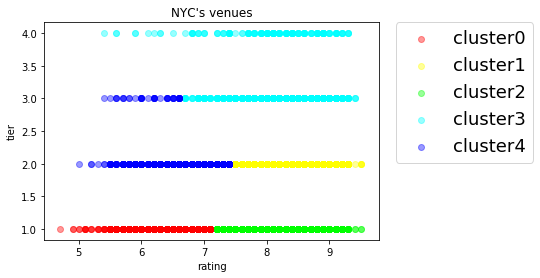

In [49]:
plot_clastered_venues('NYC\'s venues',areas[1])

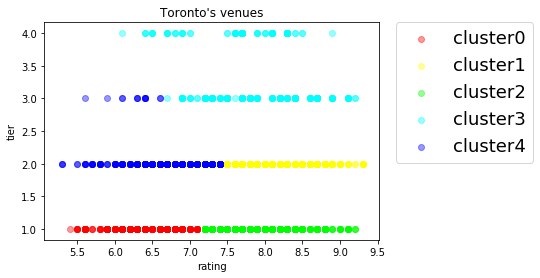

In [50]:
plot_clastered_venues('Toronto\'s venues',areas[2])

In [51]:


map_ginza = folium.Map(location=[ginza_latitude, ginza_longitude], zoom_start=16)

# add markers to map  'Venue Lat','Venue Lng'
for cluster, color in zip(range(k_venues), colors):
    rows = df_venues[(df_venues['Cluster Labels'] == cluster) & (df_venues['Neighborhood'] == 'Ginza')]
    for lat, lng, name in zip(rows['Venue Lat'], rows['Venue Lng'], rows['Venue Nane']):

        label = folium.Popup(name, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=6,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.5,
            parse_html=False).add_to(map_ginza)  

display(map_ginza)

## Toronto's neigborhoods and Ginza.
Try to get neighboorhood in Toronto that is similar to Ginza.

In [52]:
# NYC_neighborhoods.json  toronto_neighborhoods.json
neighborfoods_t_g = read_neighborhood(toronto_neighborhoods_key)

neighborfoods_t_g = ['Ginza'] + neighborfoods_t_g

dict_toronto_ginza = {'Neighborhoods':neighborfoods_t_g}
# Add venues' in Ginza area to Toront neighborhood venues.
for i in range(k_venues):
    dict_toronto_ginza['venue {}'.format(i)]=[0 for j in range( len(neighborfoods_t_g) )]
                   
df_toronto_ginza = pd.DataFrame(dict_toronto_ginza)

for index, row in df_venues.iterrows():
    df_toronto_ginza.loc[df_toronto_ginza['Neighborhoods'] == row['Neighborhood'], 'venue {}'.format(row['Cluster Labels']  )] += 1
print(df_toronto_ginza.shape)
df_toronto_ginza.head()

(73, 6)


,Neighborhoods,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,0,46,13,11,1
1,Kensington Market,1,22,32,0,1
2,The Junction South,6,3,1,0,2
3,Forest Hill SE,3,1,0,0,2
4,Moore Park,0,0,0,0,0


### Neighborhood(s) of Toronto that is similar to Ginza.

In [53]:
# Drop a column
df_toronto_ginza=df_toronto_ginza.drop(columns=['Neighborhoods'],axis='columns')

kmeans = KMeans(n_clusters=k_neighbors, random_state = 0)
kmeans_result = kmeans.fit(df_toronto_ginza)
df_toronto_ginza['Neighborhoods'] = neighborfoods_t_g
df_toronto_ginza['Cluster'] = kmeans_result.labels_
fixed_columns = list(df_toronto_ginza.columns[-2:]) + list(df_toronto_ginza.columns[:-2])

df_toronto_ginza = df_toronto_ginza[fixed_columns]
df_toronto_ginza.head(10)

,Neighborhoods,Cluster,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,7,0,46,13,11,1
1,Kensington Market,5,1,22,32,0,1
2,The Junction South,0,6,3,1,0,2
3,Forest Hill SE,3,3,1,0,0,2
4,Moore Park,3,0,0,0,0,0
5,Rathnelly,3,3,1,0,0,2
6,The Beaches West,3,2,1,1,0,4
7,Trinity,6,2,17,9,5,5
8,Ryerson,4,21,18,13,4,20
9,Roncesvalles,3,1,3,0,1,1


In [54]:
# Show Gibza and neighborhood(s) of Toronto that is similar to Ginza.
df_toronto_ginza[df_toronto_ginza.Cluster == df_toronto_ginza.iloc[0].Cluster]

,Neighborhoods,Cluster,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,7,0,46,13,11,1


It seems there is no neighborhood that is similar to Ginza in Toronto.

## NYC's neighborhoods and Ginza.
Try to get neighboorhood in NYC that is similar to Ginza.

In [55]:
# NYC_neighborhoods.json 
neighborfoods_n_g = read_neighborhood(nyc_neighborhoods_key)

neighborfoods_n_g = ['Ginza'] + neighborfoods_n_g

dict_nyc_ginza = {'Neighborhoods':neighborfoods_n_g}
# Add venues' in Ginza area to NYC neighborhood venues.
for i in range(k_venues):
    dict_nyc_ginza['venue {}'.format(i)]=[0 for j in range( len(neighborfoods_n_g) )]
                   
df_nyc_ginza = pd.DataFrame(dict_nyc_ginza)

for index, row in df_venues.iterrows():
    df_nyc_ginza.loc[df_nyc_ginza['Neighborhoods'] == row['Neighborhood'], 'venue {}'.format(row['Cluster Labels']  )] += 1
print(df_nyc_ginza.shape)
df_nyc_ginza.head(20)

(306, 6)


,Neighborhoods,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,0,46,13,11,1
1,Wakefield,2,0,0,0,1
2,Co-op City,2,0,0,0,1
3,Eastchester,4,1,3,1,1
4,Fieldston,0,0,0,0,0
5,Riverdale,3,9,4,2,14
6,Kingsbridge,10,6,10,0,4
7,Marble Hill,4,1,3,1,1
8,Woodlawn,2,2,2,0,0
9,Norwood,7,0,3,0,2


In [56]:
# Drop a column.
df_nyc_ginza=df_nyc_ginza.drop(columns=['Neighborhoods'],axis='columns')
# Clustering neighborhoods
kmeans = KMeans(n_clusters=k_neighbors, random_state=0)
kmeans_result = kmeans.fit(df_nyc_ginza)
df_nyc_ginza['Neighborhoods'] = neighborfoods_n_g
df_nyc_ginza['Cluster'] = kmeans_result.labels_
fixed_columns = list(df_nyc_ginza.columns[-2:]) + list(df_nyc_ginza.columns[:-2])

df_nyc_ginza = df_nyc_ginza[fixed_columns]
df_nyc_ginza.head(10)

,Neighborhoods,Cluster,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,5,0,46,13,11,1
1,Wakefield,0,2,0,0,0,1
2,Co-op City,0,2,0,0,0,1
3,Eastchester,4,4,1,3,1,1
4,Fieldston,0,0,0,0,0,0
5,Riverdale,2,3,9,4,2,14
6,Kingsbridge,2,10,6,10,0,4
7,Marble Hill,4,4,1,3,1,1
8,Woodlawn,0,2,2,2,0,0
9,Norwood,4,7,0,3,0,2


### Neighborhood(s) of NYC that is similar to Ginza.

In [57]:
# Show Gibza and neighborhood(s) of NYC that is similar to Ginza.
df_result = df_nyc_ginza[df_nyc_ginza.Cluster == df_nyc_ginza.iloc[0].Cluster]
df_result

,Neighborhoods,Cluster,venue 0,venue 1,venue 2,venue 3,venue 4
0,Ginza,5,0,46,13,11,1
97,North Side,5,0,46,33,12,6
115,Midtown,5,0,39,35,22,1
118,East Village,5,0,51,27,17,0
121,Little Italy,5,0,48,33,17,0
128,Financial District,5,0,36,46,12,0
180,Murray Hill,5,4,58,25,22,20
248,Noho,5,0,57,29,14,0
250,Midtown South,5,0,56,26,16,0


9 neighborhoods that are similar to Ginza.

Ginza


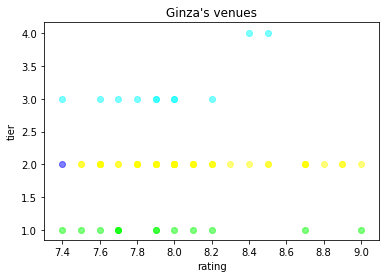

<Figure size 432x288 with 0 Axes>

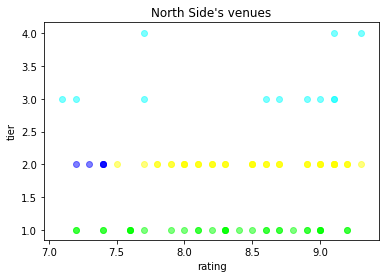

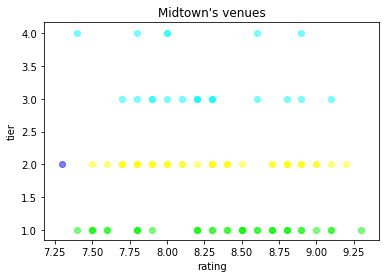

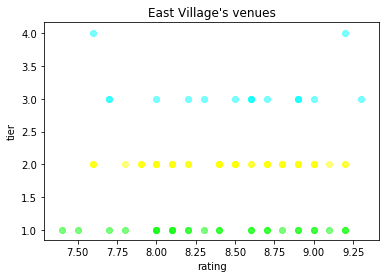

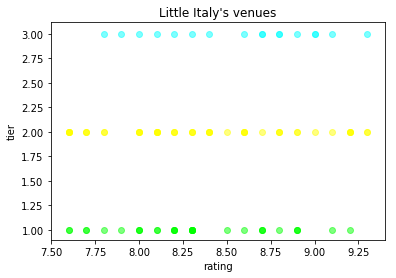

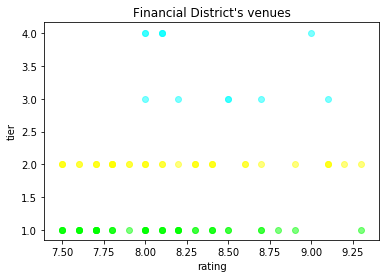

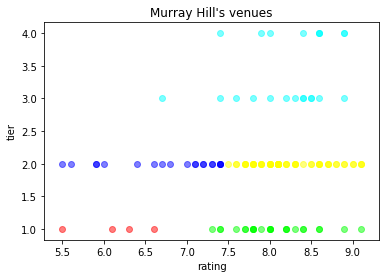

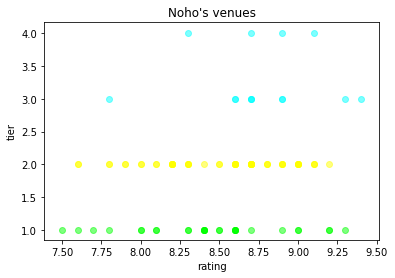

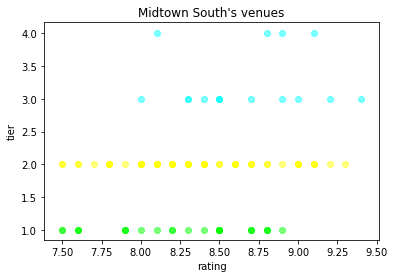

In [58]:
print(df_result.iat[0,0])
colors = ['#ff0000','#ffff00','#00ff00','#00ffff','#0000ff','#ff00ff']

num_of_row = df_result.shape[0] - 1

fig = plt.figure()
#gs = fig.add_gridspec(2, 1)
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('tier')
ax.set_xlabel('rating')
ax.set_title('Ginza\'s venues')
for cluster, color in zip(range(k_venues), colors):
    area_rows = df_venues[(df_venues['Cluster Labels'] == cluster) & (df_venues['Neighborhood'] == 'Ginza')]
    area_tier = area_rows['Venue Tier']
    area_ratingr = area_rows['Venue Rating']

    ax.scatter(area_ratingr, area_tier, alpha=0.5,c=color)
plt.show()

# Show plots of venues of neghborhoodsin NYC .
fig = plt.figure()
for i in range(num_of_row) : 
    fig = plt.figure()
    
    ax = fig.add_subplot(1,1,1)
    ax.set_ylabel('tier')
    ax.set_xlabel('rating')
    ax.set_title('{0}\'s venues'.format(df_result.iat[i+1,0]))
    for cluster, color in zip(range(k_venues), colors):
        area_rows = df_venues[(df_venues['Cluster Labels'] == cluster)
                              & (df_venues['Neighborhood'] == df_result.iat[i+1,0])]
        area_tier = area_rows['Venue Tier']
        area_ratingr = area_rows['Venue Rating']

        ax.scatter(area_ratingr, area_tier, alpha=0.5,c=color)    
    plt.show()

that's it.